In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime
import ta
import logging
import os
import uuid

from scipy.fft import rfft, rfftfreq
from scipy.signal import correlate, correlation_lags

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Attention

from tensorflow.keras import callbacks
from tensorflow.keras.regularizers import l1, l2, l1_l2


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

import mlflow
import mlflow.tensorflow
import mlflow.pyfunc
import joblib


import random

# Set random seeds for reproducibility
np.random.seed(69)
tf.random.set_seed(69)
random.seed(69)

# Check Tensorflow-GPU enabled

In [17]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Additional check to see if GPU is being used
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is not using the GPU.")


TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.16.2
TensorFlow is using the GPU.


# Data Fetch, preprociessing, feature engineering

In [18]:
import requests
import pandas as pd
import datetime
import numpy as np
import ta
from numpy.fft import rfft, rfftfreq
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def fetch_historical_data(symbol: str, interval: str, start_time, end_time):
    """
    Fetch historical data from Binance API in chunks.

    Parameters:
    symbol (str): The trading pair symbol (e.g., 'BTCUSDC').
    interval (str): The interval for the data (e.g., '1h' for 1-hour intervals).
    start_time (int): The start time in milliseconds since epoch.
    end_time (int): The end time in milliseconds since epoch.

    Returns:
    pd.DataFrame: A DataFrame containing the historical close prices and volumes.

    Raises:
    requests.exceptions.RequestException: If there is an issue with the API request.
    """
    df_list = []  # List to store data chunks
    current_time = start_time  # Initialize current time to start time

    while current_time < end_time:
        # Construct the API URL with the given parameters
        url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&startTime={current_time}&endTime={end_time}'

        try:
            # Fetch data from the API
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for HTTP errors
            data = response.json()

            if not data:
                break  # Exit the loop if no data is returned

            # Create a DataFrame from the fetched data
            df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])

            # Convert timestamp to datetime and set as index
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            # Convert 'close' and 'volume' columns to float
            df['close'] = df['close'].astype(float)
            df['volume'] = df['volume'].astype(float)

            # Append the relevant columns to the list
            df_list.append(df[['close', 'volume']])

            # Update current time to the next chunk
            current_time = int(df.index[-1].timestamp() * 1000) + 1

        except requests.exceptions.RequestException as e:
            logging.error(f"API request failed: {e}")
            break

    # Concatenate all data chunks into a single DataFrame
    if df_list:
        final_df = pd.concat(df_list)
    else:
        final_df = pd.DataFrame(columns=['close', 'volume'])
    
    logging.info('Data fetched successfully!')
    return final_df

def preprocess_data(data):
    """
    Preprocess the data by handling missing values, encoding categorical variables, and normalizing numerical features.

    Parameters:
    data (pd.DataFrame): The raw data to be preprocessed.

    Returns:
    pd.DataFrame: The preprocessed data.
    """
    # Convert the index to a regular column called 'datetime'
    data.index = pd.to_datetime(data.index)
    data.reset_index(inplace=True)
    data.rename(columns={'timestamp': 'datetime'}, inplace=True)

    # Extract year, month, and day from 'datetime'
    data['Year'] = data['datetime'].dt.year
    data['Month'] = data['datetime'].dt.month
    data['Day'] = data['datetime'].dt.day
    data['Hour'] = data['datetime'].dt.hour
    #data.drop('datetime', axis=1, inplace=True)

    logging.info('Data preprocessed successfully!')
    return data

def calculate_technical_indicators(data):
    """
    Calculate technical indicators.

    Parameters:
    data (pd.DataFrame): The preprocessed data.

    Returns:
    pd.DataFrame: The data with technical indicators.
    """
    data['RSI'] = ta.momentum.rsi(data['close'], window=14)
    data['MACD'] = ta.trend.macd(data['close'])
    bollinger = ta.volatility.BollingerBands(data['close'])
    data['Bollinger_Upper'], data['Bollinger_Middle'], data['Bollinger_Lower'] = ta.volatility.BollingerBands(data['close']).bollinger_hband(), ta.volatility.BollingerBands(data['close']).bollinger_mavg(), ta.volatility.BollingerBands(data['close']).bollinger_lband()


    print("Technical indicators calculated successfully.")
    logging.info('Data preprocessed successfully!')
    return data

def calculate_cyclical_features(data):
    """
    Calculate cyclical features.

    Parameters:
    data (pd.DataFrame): The data with technical indicators.

    Returns:
    pd.DataFrame: The data with cyclical features.
    """
    data['Year_sin'] = np.sin(2 * np.pi * data['Year'] / 2024.0)  # Assuming a cycle of 2024 years
    data['Year_cos'] = np.cos(2 * np.pi * data['Year'] / 2024.0)
    data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12.0)
    data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12.0)
    data['Day_sin'] = np.sin(2 * np.pi * data['Day'] / 31.0)  # Assuming a maximum of 31 days in a month
    data['Day_cos'] = np.cos(2 * np.pi * data['Day'] / 31.0)
    data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24.0)
    data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24.0)

    data.drop(['Hour', 'Month', 'Year', 'Day'], axis = 1, inplace = True)
    
    logging.info('Cyclical features calculated successfully!')
    return data

def calculate_fourier_features(data):
    """
    Calculate Fourier transform and frequencies.

    Parameters:
    data (pd.DataFrame): The data with cyclical features.

    Returns:
    pd.DataFrame: The data with Fourier features.
    """
    N = len(data['close'])  # Number of points in the sample
    T = 60  # Number of seconds between two samples (6 hours in seconds)

    yf = rfft(data['close'].values)  # Real Fourier Transform
    xf = rfftfreq(N, T)  # Frequencies associated with the Fourier Transform

    # Energy in Frequency Bands
    low_freq_energy = np.sum(np.abs(yf[(xf >= 0) & (xf < 1 / (24 * 3600))]) ** 2)  # Energy in low frequencies (daily)
    high_freq_energy = np.sum(np.abs(yf[(xf >= 1 / (24 * 3600)) & (xf < 1 / 3600)]) ** 2)  # Energy in higher frequencies (hourly)
    hourly_freq_energy = np.sum(np.abs(yf[(xf >= 1 / 3600) & (xf < 1 / 60)]) ** 2)  # Energy in higher frequencies (hourly)

    # Calculate other Statistical Fourier Transformed Features
    mean_amplitude = np.mean(np.abs(yf))
    variance_amplitude = np.var(np.abs(yf))
    skewness_amplitude = np.mean((np.abs(yf) - mean_amplitude) ** 3) / (variance_amplitude ** 1.5)
    kurtosis_amplitude = np.mean((np.abs(yf) - mean_amplitude) ** 4) / (variance_amplitude ** 2)

    # Add Energy frequency in bands to our dataframe
    data['low_freq_energy'] = low_freq_energy
    data['high_freq_energy'] = high_freq_energy
    data['hourly_freq_energy'] = hourly_freq_energy
    data['mean_amplitude'] = mean_amplitude
    data['variance_amplitude'] = variance_amplitude
    data['skewness_amplitude'] = skewness_amplitude
    data['kurtosis_amplitude'] = kurtosis_amplitude

    logging.info('Fourier transform and frequencies calculated successfully!')
    return data

def calculate_rolling_means(data):
    """
    Calculate rolling means for several windows.

    Parameters:
    data (pd.DataFrame): The data with Fourier features.

    Returns:
    pd.DataFrame: The data with rolling means.
    """
    data['rolling_mean_close_6'] = data['close'].rolling(window=6).mean()
    data['rolling_mean_close_12'] = data['close'].rolling(window=12).mean()
    data['rolling_mean_close_24'] = data['close'].rolling(window=24).mean()
    data['rolling_mean_close_48'] = data['close'].rolling(window=48).mean()
    data['rolling_mean_close_72'] = data['close'].rolling(window=72).mean()
    data['rolling_mean_close_100'] = data['close'].rolling(window=100).mean()
    data['rolling_mean_close_120'] = data['close'].rolling(window=100).mean()
    data['rolling_mean_close_150'] = data['close'].rolling(window=150).mean()
    data['rolling_mean_close_200'] = data['close'].rolling(window=200).mean()

    logging.info('Rolling means calculated successfully!')
    return data

def calculate_ema(data):
    """
    Calculate Exponential Moving Average (EMA) for several windows.

    Parameters:
    data (pd.DataFrame): The data with rolling means.

    Returns:
    pd.DataFrame: The data with EMA.
    """
    data['EMA_6'] = data['close'].ewm(span=6, adjust=False).mean()
    data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
    data['EMA_24'] = data['close'].ewm(span=24, adjust=False).mean()
    data['EMA_48'] = data['close'].ewm(span=48, adjust=False).mean()
    data['EMA_72'] = data['close'].ewm(span=72, adjust=False).mean()
    data['EMA_100'] = data['close'].ewm(span=100, adjust=False).mean()
    data['EMA_150'] = data['close'].ewm(span=150, adjust=False).mean()

    
    logging.info('EMA calculated successfully!')
    return data

def drop_missing_values(data):
    """
    Drop all rows with missing values.

    Parameters:
    data (pd.DataFrame): The data with EMA.

    Returns:
    pd.DataFrame: The data with missing values dropped.
    """
    data.dropna(inplace=True)
    
    logging.info('Rows with missing values dropped successfully!')
    return data

# Define parameters
symbol = 'BTCUSDC'  # Trading pair symbol
interval = '1h'  # Interval for the data (1-hour intervals)
start_time = int(datetime.datetime(2023, 1, 1).timestamp() * 1000)  # Start time in milliseconds
end_time = int(datetime.datetime.now().timestamp() * 1000)  # End time in milliseconds (current time)

#######################################################################################################################
# Create the 'data' directory if it doesn't exist
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# Fetch data
data_bronze = fetch_historical_data(symbol, interval, start_time, end_time)

# Save raw data to CSV
data_bronze.to_csv(os.path.join(data_dir, 'bronze.csv'), index=False)
logging.info('Raw data saved to bronze.csv')

# BRONZE: Preprocess data
data_silver= preprocess_data(data_bronze)
data_silver.to_csv(os.path.join(data_dir, 'silver.csv'), index=False)
logging.info('Preprocessed data saved to silver1.csv')

# SILVER: Feature engineering
data_with_indicators = calculate_technical_indicators(data_silver)
data_with_cyclical = calculate_cyclical_features(data_with_indicators)
data_with_fourier = calculate_fourier_features(data_with_cyclical)
data_with_rolling_means = calculate_rolling_means(data_with_fourier)
data_with_ema = calculate_ema(data_with_rolling_means)
data_gold = drop_missing_values(data_with_ema)

# GOLD: Save preprocessed and feature-engineered data to CSV
data_gold.to_csv(os.path.join(data_dir, 'gold.csv'), index=False)
logging.info('Feature-engineered data saved to gold.csv')

# Log the final data shape
logging.info(f"Final data shape: {data_gold.shape}")
print(f"Final data shape: {data_gold.shape}")

2024-11-29 12:22:53,722 - INFO - Data fetched successfully!
2024-11-29 12:22:53,780 - INFO - Raw data saved to bronze.csv
2024-11-29 12:22:53,794 - INFO - Data preprocessed successfully!
2024-11-29 12:22:53,829 - INFO - Preprocessed data saved to silver1.csv
2024-11-29 12:22:53,836 - INFO - Data preprocessed successfully!
2024-11-29 12:22:53,840 - INFO - Cyclical features calculated successfully!
2024-11-29 12:22:53,843 - INFO - Fourier transform and frequencies calculated successfully!
2024-11-29 12:22:53,845 - INFO - Rolling means calculated successfully!
2024-11-29 12:22:53,847 - INFO - EMA calculated successfully!
2024-11-29 12:22:53,850 - INFO - Rows with missing values dropped successfully!


Technical indicators calculated successfully.


2024-11-29 12:22:54,140 - INFO - Feature-engineered data saved to gold.csv
2024-11-29 12:22:54,140 - INFO - Final data shape: (14878, 39)


Final data shape: (14878, 39)


# Training

2024-11-26 18:33:38,944 - INFO - Training dataset created successfully!
2024-11-26 18:33:38,964 - INFO - Training dataset created successfully!
2024-11-26 18:33:38,969 - INFO - n_timesteps: 100
2024-11-26 18:33:38,969 - INFO - X_train shape: (11748, 100, 17)
2024-11-26 18:33:38,970 - INFO - y_train shape: (11748,)
2024-11-26 18:33:38,970 - INFO - X_test shape: (2863, 100, 17)
2024-11-26 18:33:38,970 - INFO - y_test shape: (2863,)
2024/11/26 18:33:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/11/26 18:33:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/11/26 18:33:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
/Users/juanpablofuquenpaez/cryptopythia/mlflowtensor/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Epoch 1/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 5.1726 - mse: 0.8034 - val_loss: 2.3069 - val_mse: 0.2348 - learning_rate: 0.0010
Epoch 2/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 1.9180 - mse: 0.1987 - val_loss: 1.0547 - val_mse: 0.0878 - learning_rate: 0.0010
Epoch 3/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.9131 - mse: 0.0889 - val_loss: 0.5709 - val_mse: 0.0689 - learning_rate: 0.0010
Epoch 4/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.5008 - mse: 0.0655 - val_loss: 0.3329 - val_mse: 0.0556 - learning_rate: 0.0010
Epoch 5/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.3033 - mse: 0.0600 - val_loss: 0.2153 - val_mse: 0.0543 - learning_rate: 0.0010
Epoch 6/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.2019 - mse: 0.0585 - val_loss: 0.1387 - val_mse: 0.0398 - learning_rate: 0.0010
Epoch 7/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.1436 - mse: 0.0552 - val_loss: 0.1225 - val_mse: 0.0595 - learning_rate: 0.0010

2024-11-26 18:35:31,263 - INFO - Shape of y_pred: (2863, 1)
2024-11-26 18:35:31,263 - INFO - Shape of y_test: (2863,)
2024/11/26 18:35:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/26 18:35:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/26 18:35:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/11/26 18:35:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'scaler' already exists. Creating a new version of this model...
2024/11/26 18:35:34 INFO m

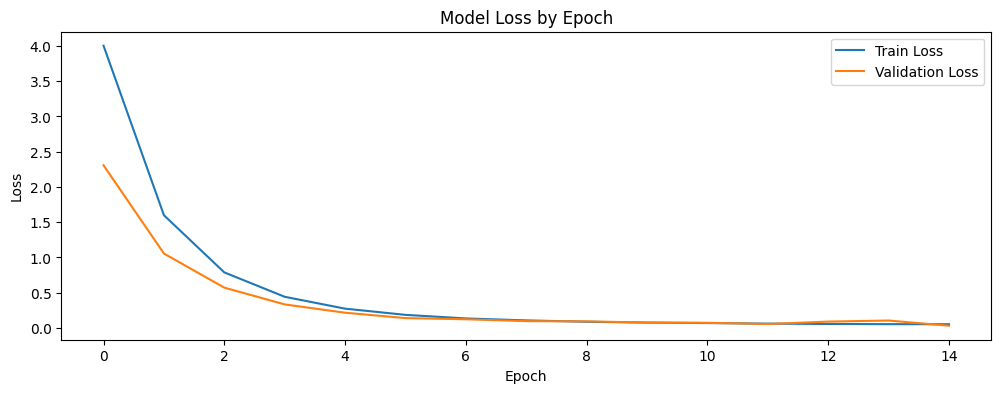

2024-11-26 18:35:35,146 - INFO - Training process completed successfully.
2024-11-26 18:35:35,146 - INFO - MSE: 0.025130989030003548, R2 Score: 0.7735474160515899


🏃 View run LSTM_conv1D_5 at: http://localhost:8000/#/experiments/1/runs/87faceaffbdb4edf818d5a3fd54eef1f
🧪 View experiment at: http://localhost:8000/#/experiments/1
Scaler: RobustScaler()
Model: <Sequential name=sequential_7, built=True>


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import callbacks
import mlflow
import mlflow.tensorflow
import mlflow.sklearn
import joblib
import uuid
import logging
import os
from databricks.feature_engineering import FeatureEngineeringClient, FeatureLookup

# Training Dataset creation based on Gold
def create_training_dataset(dataset, n_timesteps):
    """
    Create a dataset for training and testing.

    Parameters:
    dataset (np.ndarray): The dataset to be transformed.
    n_timesteps (int): The number of past timesteps to use for prediction.

    Returns:
    np.ndarray, np.ndarray: The features and target values.
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - n_timesteps):
        x = dataset[i:i + n_timesteps, :]  # All features between t-n and t-1
        y = dataset[i + n_timesteps, 0]  # Closing price at instant t (assuming 'close' is the first column)
        dataX.append(x)
        dataY.append(y)

    logging.info("Training dataset created successfully!")
    return np.array(dataX), np.array(dataY)

# Model Training
def train_model(data_final, run_name, n_timesteps=300, epochs=1, batch_size=32, learning_rate=0.001):
    # Select the specified features
    selected_features = ['EMA_6',
                         'rolling_mean_close_48',
                        'EMA_72',
                        'rolling_mean_close_200',
                        'EMA_150',
                        'rolling_mean_close_72',
                        'EMA_100',
                        'rolling_mean_close_150',
                        'rolling_mean_close_120',
                        'EMA_48',
                        'rolling_mean_close_6',
                        'rolling_mean_close_100',
                        'Bollinger_Upper',
                        'EMA_12',
                        'EMA_24',
                        'rolling_mean_close_12',
                        'close']

    # Ensure the selected features are in the dataset
    data_final = data_final[selected_features]
    # Train-test split: shuffle=False to maintain the temporal order of the data.
    df_train, df_test = train_test_split(data_final, test_size=0.2, shuffle=False)

    # Use StandardScaler to scale the data
    scaler = RobustScaler() #StandardScaler()

    df_train_scaled = scaler.fit_transform(df_train)
    df_test_scaled = scaler.transform(df_test)

    # Create the dataset for training and testing with n timesteps
    X_train, y_train = create_training_dataset(df_train_scaled, n_timesteps)
    X_test, y_test = create_training_dataset(df_test_scaled, n_timesteps)

    # Print the shapes of the training data
    logging.info(f"n_timesteps: {n_timesteps}")
    logging.info(f"X_train shape: {X_train.shape}")
    logging.info(f"y_train shape: {y_train.shape}")
    logging.info(f"X_test shape: {X_test.shape}")
    logging.info(f"y_test shape: {y_test.shape}")

    # Define tracking url experiment name, run name and artifact_path name
    # Set our tracking server uri for logging
    mlflow.set_tracking_uri('http://localhost:8000')
    experiment_name = "Bitcoin Forecasting"
    mlflow.set_experiment(experiment_name)
    mlflow.autolog()

    with mlflow.start_run(run_name=run_name) as run:

        model = Sequential([Conv1D(filters=5, kernel_size=3, activation='linear', padding='same', input_shape=(n_timesteps, X_train.shape[2]),kernel_regularizer=l2(0.01)),
            MaxPooling1D(pool_size=2),
            Dropout(0.4),

            LSTM(4, input_shape=(n_timesteps, X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.3),

            LSTM(3, return_sequences=True, kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.2),

            LSTM(2, return_sequences=False, kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.2),

            Dense(1, activation='linear', kernel_regularizer=l2(0.01))
        ])

        # Hyperparameters
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        loss = "mean_squared_error"
        # Compile the model
        model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])
        # Callbacks
        early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=6, mode='min', restore_best_weights=True)
        lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.8, verbose=2, mode='min')
        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[lr_plateau, early_stopping], validation_split=0.2, validation_data=(X_test, y_test))

        # Predict on the test set
        y_pred = model.predict(X_test)
        # Ensure y_pred and y_test have the same shape
        logging.info(f"Shape of y_pred: {y_pred.shape}")
        logging.info(f"Shape of y_test: {y_test.shape}")

        # Log hyperparameters
        mlflow.log_param("n_timesteps", n_timesteps)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("loss", loss)

        # Log the scaler and the model with mlflow
        scaler_name = f"{run_name}_scaler"
        model_name = run_name

        mlflow.sklearn.log_model(scaler, scaler_name)
        mlflow.tensorflow.log_model(model, model_name)

        # Register the scaler in the MLflow Model Registry
        scaler_uri = f"runs:/{mlflow.active_run().info.run_id}/{scaler_name}"
        scaler_result = mlflow.register_model(scaler_uri, scaler_name)
        logging.info(f"Scaler registered: {scaler_result}")

        # Register the model in the MLflow Model Registry
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_name}"
        model_result = mlflow.register_model(model_uri, model_name)
        logging.info(f"Model registered: {model_result}")

        # Transition the model version to "Staging"
        client = mlflow.tracking.MlflowClient()
        client.transition_model_version_stage(name=model_name, version=model_result.version, stage="Staging")
        logging.info(f"Model transitioned to Staging: {model_result.version}")

        # Transition the scaler version to "Staging"
        client.transition_model_version_stage(name=scaler_name, version=scaler_result.version, stage="Staging")
        logging.info(f"Scaler transitioned to Staging: {scaler_result.version}")

        # Metrics
        # Ensure y_test and y_pred are 2D arrays
        y_test = np.squeeze(y_test) ######## for bilstm
        y_pred = np.squeeze(y_pred) ########

        # Calculate Metrics
        # Calculate MSE
        mse = tf.keras.losses.MeanSquaredError()
        mse_value = mse(y_test, y_pred).numpy()
        # Calculate R2 score
        r2_value = r2_score(y_test, y_pred)
        # Log metrics
        mlflow.log_metric("mse", mse_value)
        mlflow.log_metric("r2_score", r2_value)

        # Plot training and validation loss
        plt.figure(figsize=(12, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss by Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.savefig('model_loss_by_epoch.png')
        plt.show()
        # Log the plot as an artifact
        mlflow.log_artifact('model_loss_by_epoch.png')

    # Logging and Monitoring
    logging.info("Training process completed successfully.")
    logging.info(f"MSE: {mse_value}, R2 Score: {r2_value}")
    return selected_features, scaler, model, y_pred, y_test, df_test, n_timesteps  # y_pred, df_test, n_timesteps: just for the visualization

# Example usage
data_final = pd.read_csv('data/gold.csv', index_col=False)

# Set up an experiment to organize runs
selected_features, scaler, model, y_pred, y_test, df_test, n_timesteps = train_model(data_final, run_name = "LSTM_conv1D_35")

# Now you can use the scaler and model directly
print("Scaler:", scaler)
print("Model:", model)


# Plotting test vs predicted

Length of y_test_original: 2913
Length of y_pred_original: 2913


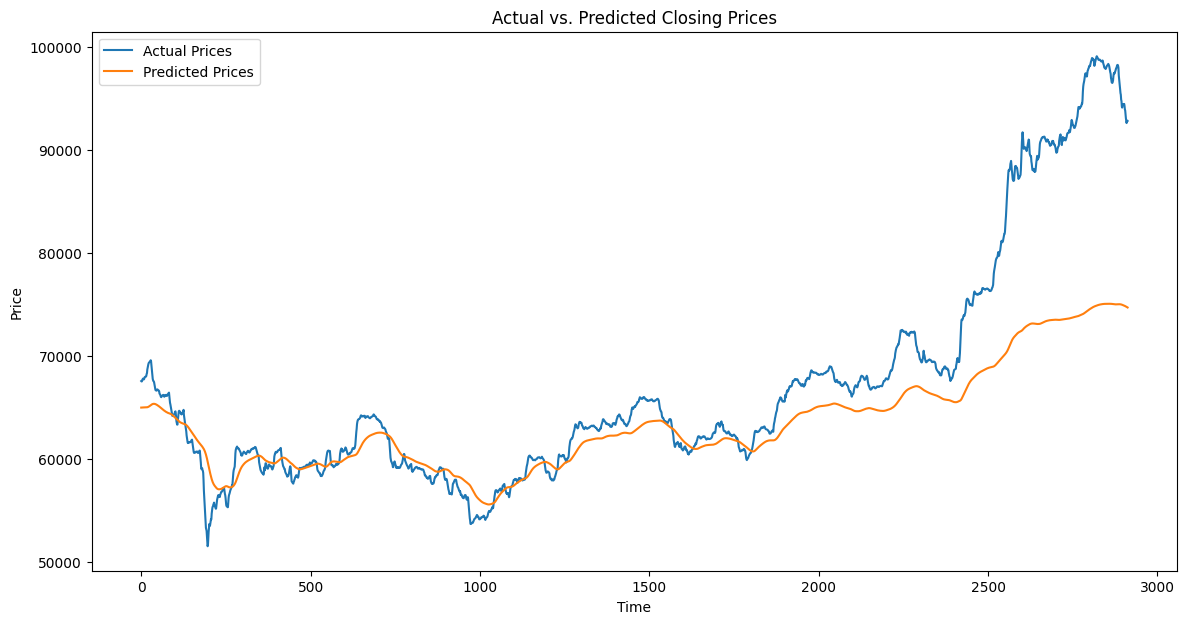

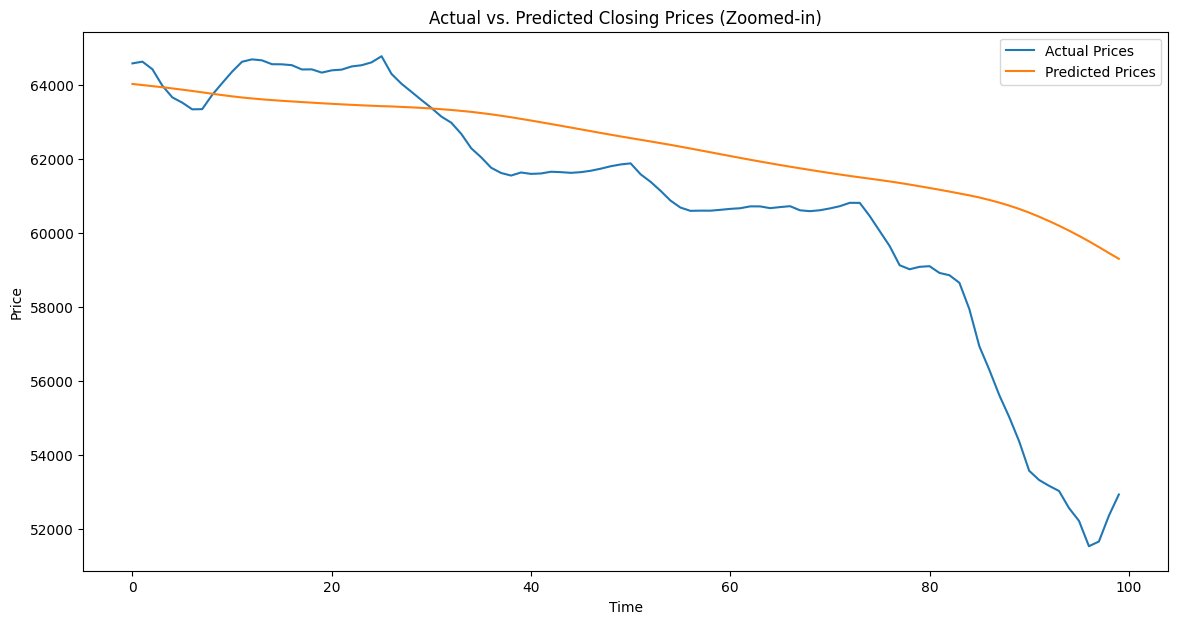

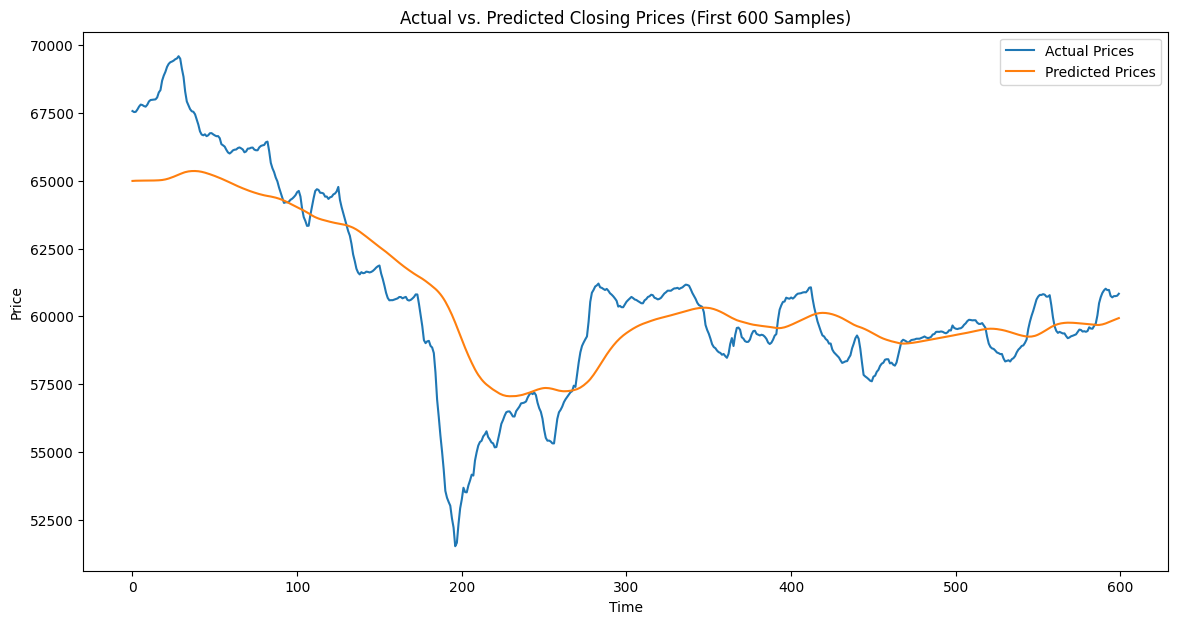

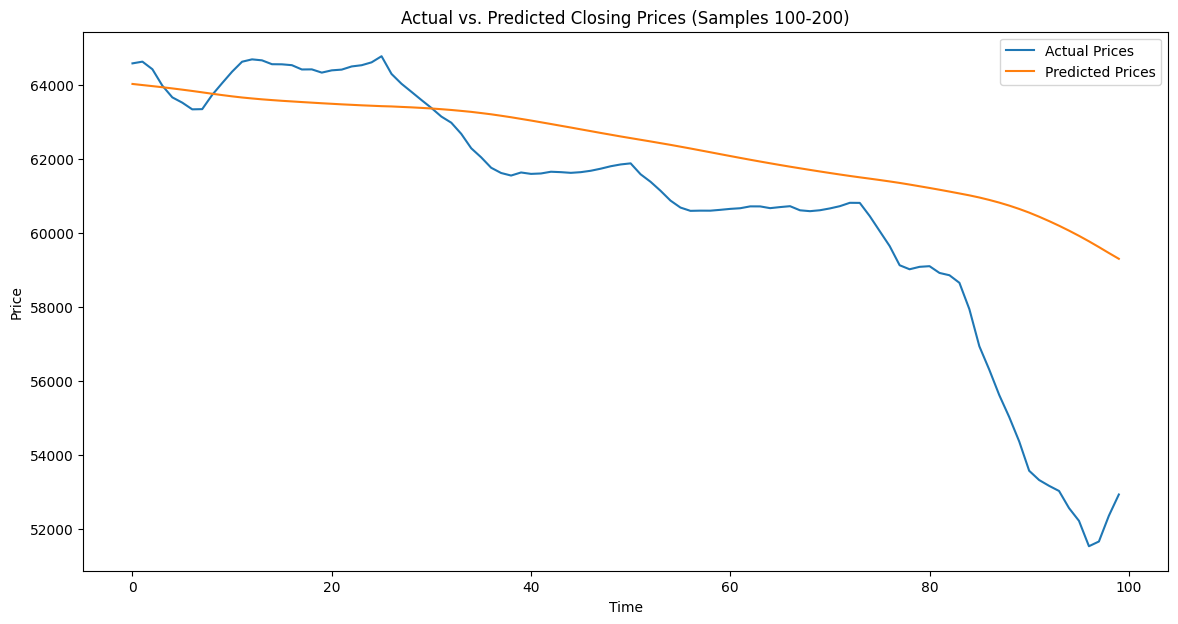

Mean Squared Error (MSE): 53569852.8060594
Root Mean Squared Error (RMSE): 7319.142901054699
R-squared (R²): 0.5591680866182394


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Assuming y_pred and y_test are already defined and scaled
# y_pred: array of predictions, y_test: array of actual values

# Step 1: Reshape Predictions
y_pred_reshaped = y_pred.reshape(-1, 1)  # Ensure it's a column vector

# Step 2: Prepare Full Predictions Array
# Assuming the original data has 32 features
num_features = len(selected_features)
predictions_full = np.zeros((y_pred_reshaped.shape[0], num_features))
predictions_full[:, 0] = y_pred_reshaped.flatten()  # Fill the first column with the reshaped predictions

# Step 3: Inverse Transform
# Assuming scaler is already defined and fitted
y_pred_original = scaler.inverse_transform(predictions_full)[:, 0]

# Ensure y_test has the correct shape for inverse transformation
y_test_reshaped = y_test.reshape(-1, 1)
test_full = np.zeros((y_test_reshaped.shape[0], num_features))
test_full[:, 0] = y_test_reshaped.flatten()
y_test_original = scaler.inverse_transform(test_full)[:, 0]

# Check the lengths of y_test_original and y_pred_original
print(f"Length of y_test_original: {len(y_test_original)}")
print(f"Length of y_pred_original: {len(y_pred_original)}")

# Ensure the lengths match
min_length = min(len(y_test_original), len(y_pred_original))
y_test_original = y_test_original[:min_length]
y_pred_original = y_pred_original[:min_length]

# Step 4: Plot Actual vs. Predicted Prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices')
plt.plot(y_pred_original, label='Predicted Prices')
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Zoomed-in plot for samples 100-200
plt.figure(figsize=(14, 7))
plt.plot(y_test_original[100:200], label='Actual Prices')
plt.plot(y_pred_original[100:200], label='Predicted Prices')
plt.title('Actual vs. Predicted Closing Prices (Zoomed-in)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 5: Additional Plots
# Plot for the first 600 samples
plt.figure(figsize=(14, 7))
plt.plot(y_test_original[:600], label='Actual Prices')
plt.plot(y_pred_original[:600], label='Predicted Prices')
plt.title('Actual vs. Predicted Closing Prices (First 600 Samples)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for samples 100-200 again
plt.figure(figsize=(14, 7))
plt.plot(y_test_original[100:200], label='Actual Prices')
plt.plot(y_pred_original[100:200], label='Predicted Prices')
plt.title('Actual vs. Predicted Closing Prices (Samples 100-200)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 6: Calculate and Print Metrics
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Inference using model with best R2 score

In [ ]:
import pandas as pd
import numpy as np
import logging
from datetime import timedelta
import mlflow
import mlflow.tensorflow
import mlflow.sklearn
import os


# Preprocess the data for inference
def preprocess_data(selected_features, data, scaler, n_timesteps):
    """
    Preprocess the data for inference.

    Parameters:
    data (pd.DataFrame): The data to be preprocessed.
    scaler (RobustScaler): The loaded scaler.
    n_timesteps (int): The number of past timesteps to use for prediction.

    Returns:
    np.ndarray: The preprocessed data ready for inference.
    """
    # Ensure the selected features are in the dataset
    data = data[selected_features]

    # Scale the data
    data_scaled = scaler.transform(data)
    dataX = []
    for i in range(len(data_scaled) - n_timesteps + 1):
        x = data_scaled[i:i + n_timesteps, :]
        dataX.append(x)
    return np.array(dataX)

# Make predictions using the loaded model
def make_predictions(model, dataX):
    """
    Make predictions using the loaded model.

    Parameters:
    model (tf.keras.Model): The loaded model.
    dataX (np.ndarray): The preprocessed data ready for inference.

    Returns:
    np.ndarray: The predicted values.
    """
    y_pred = model.predict(dataX)
    return y_pred

# Forecast future values using the trained model until a specified target date
def forecast_future_values(model, scaler, data, n_timesteps, target_date, date_column='datetime'):
    """
    Forecast future values using the trained model until a specified target date.

    Parameters:
    model (tf.keras.Model): The loaded model.
    scaler (RobustScaler): The loaded scaler.
    data (pd.DataFrame): The data used for training.
    n_timesteps (int): The number of past timesteps to use for prediction.
    target_date (str): The target date until which to forecast.
    date_column (str): The column name for the date in the data.

    Returns:
    pd.DataFrame: The forecasted values with dates.
    """
    forecasted_values = []
    forecasted_dates = []

    current_data = data.drop(columns=[date_column]).values
    last_date = pd.to_datetime(data[date_column].iloc[-1])
    target_date = pd.to_datetime(target_date)

    while last_date < target_date:
        dataX = preprocess_data(data.columns.drop(date_column), pd.DataFrame(current_data, columns=data.columns.drop(date_column)), scaler, n_timesteps)
        y_pred = make_predictions(model, dataX)
        forecasted_value = y_pred[-1]  # Take the last predicted value
        forecasted_values.append(forecasted_value)

        # Append the forecasted value to the current data for the next prediction
        new_row = np.zeros((1, current_data.shape[1]))  # Create a new row with the same number of columns
        new_row[0, :-1] = current_data[-1, 1:]  # Copy the last row except the first column
        new_row[0, 0] = forecasted_value  # Set the forecasted value in the first column
        current_data = np.vstack((current_data, new_row))

        # Update the last date
        last_date += timedelta(hours=1)  # Assuming hourly data
        forecasted_dates.append(last_date)

    # Reshape predictions to match the shape (n_timesteps,)
    forecasted_values = np.array(forecasted_values).reshape(-1, 1)

    # Create an array with the same number of features as the original data
    forecasted_full = np.zeros((forecasted_values.shape[0], data.shape[1] - 1))  # Exclude the date column
    forecasted_full[:, 0] = forecasted_values[:, 0]  # Assuming 'close' is the first column (index 0)

    # Inverse transform the predictions to original scale
    forecasted_original = scaler.inverse_transform(forecasted_full)[:, 0]

    forecast_df = pd.DataFrame({'datetime': forecasted_dates, 'Forecasted_Value': forecasted_original})
    return forecast_df

# Retrieve all models registered in MLflow along with their R2 scores
def get_all_models_with_r2():
    """
    Retrieve all models registered in MLflow along with their R2 scores.

    Returns:
    list: A list of dictionaries containing model information and R2 scores.
    """
    client = mlflow.tracking.MlflowClient()

    # Get all registered models
    registered_models = client.search_registered_models()

    models_with_r2 = []

    for model in registered_models:
        model_name = model.name
        model_versions = client.search_model_versions(f"name='{model_name}'")

        for version in model_versions:
            run_id = version.run_id
            run_data = client.get_run(run_id).data
            r2_score = run_data.metrics.get('r2_score', None)

            if r2_score is not None:
                models_with_r2.append({
                    'model_name': model_name,
                    'version': version.version,
                    'run_id': run_id,
                    'r2_score': r2_score
                })
                logging.info(f"Model Name: {model_name}, Version: {version.version}, Run ID: {run_id}, R2 Score: {r2_score}")

    return models_with_r2

# Get the model with the highest R2 score
def get_best_model():
    """
    Retrieve the model with the highest R2 score.

    Returns:
    dict: A dictionary containing the model information with the highest R2 score.
    """
    models_with_r2 = get_all_models_with_r2()
    if not models_with_r2:
        raise ValueError("No valid model versions found.")

    # Find the model with the highest R2 score
    best_model = max(models_with_r2, key=lambda x: x['r2_score'])
    logging.info(f"Best Model: {best_model}")
    return best_model

# Transition the previous model back to Staging
def transition_previous_model_to_staging(best_model):
    """
    Transition the previous model back to Staging.

    Parameters:
    best_model (dict): The best model information.
    """
    client = mlflow.tracking.MlflowClient()
    model_name = best_model['model_name']
    model_versions = client.search_model_versions(f"name='{model_name}'")

    for version in model_versions:
        if version.version != best_model['version']:
            client.transition_model_version_stage(name=model_name, version=version.version, stage="Staging")
            logging.info(f"Transitioned model version {version.version} to Staging.")

# Main function to perform inference
def main(selected_features, data_path, n_timesteps, target_date, date_column='datetime'):
    # Load the data used for training
    data = pd.read_csv(data_path)

    # Filter the data to include only the selected features and the date column
    data = data[[date_column] + selected_features]

    # Get the best model based on the highest R2 score
    best_model = get_best_model()
    model_uri = f"runs:/{best_model['run_id']}/model"
    scaler_uri = f"runs:/{best_model['run_id']}/scaler"

    # Load the best model and scaler
    model = mlflow.tensorflow.load_model(model_uri)
    scaler = mlflow.sklearn.load_model(scaler_uri)

    expected_features = scaler.n_features_in_
    if data.shape[1] != expected_features + 1:  # Include the date column
        raise ValueError(f"Data has {data.shape[1]} features, but the scaler is expecting {expected_features} features plus the date column.")

    # Transition the best model to Production
    client = mlflow.tracking.MlflowClient()
    client.transition_model_version_stage(name=best_model['model_name'], version=best_model['version'], stage="Production")
    logging.info(f"Model transitioned to Production: {best_model['version']}")

    # Transition the previous model back to Staging
    transition_previous_model_to_staging(best_model)

    # Forecast future values until the specified target date
    forecasted_values = forecast_future_values(model, scaler, data, n_timesteps, target_date, date_column)

    # Output the results
    print("Forecasted values:\n", forecasted_values)

    # Save the forecasted values to a CSV file
    data_dir = 'data'
    os.makedirs(data_dir, exist_ok=True)
    forecasted_values.to_csv(os.path.join(data_dir, 'forecasted_values.csv'), index=False)

    logging.info("Forecasting completed successfully!")

# Example usage
data_path = 'data/gold.csv'
n_timesteps = 300
target_date = "2024-11-29 12:00:00"  # Replace with the target date you want to forecast until
selected_features = ['EMA_6', 'rolling_mean_close_48', 'EMA_72', 'rolling_mean_close_200', 'EMA_150', 'rolling_mean_close_72', 'EMA_100', 'rolling_mean_close_150', 'rolling_mean_close_120', 'EMA_48', 'rolling_mean_close_6', 'rolling_mean_close_100', 'Bollinger_Upper', 'EMA_12', 'EMA_24', 'rolling_mean_close_12', 'close']

# Call the main function with the correct order of arguments
main(selected_features, data_path, n_timesteps, target_date)


2024-11-29 12:24:46,208 - INFO - Model Name: LSTM_conv1D_20, Version: 1, Run ID: 47b81d3a110642958cf7746e0200a4eb, R2 Score: 0.6680339945053297
2024-11-29 12:24:46,218 - INFO - Model Name: LSTM_conv1D_20_scaler, Version: 1, Run ID: 47b81d3a110642958cf7746e0200a4eb, R2 Score: 0.6680339945053297
2024-11-29 12:24:46,230 - INFO - Model Name: LSTM_conv1D_21, Version: 1, Run ID: 63157941dd0c4c4a8b0dfb0c02e8da10, R2 Score: -0.3514227776109473
2024-11-29 12:24:46,241 - INFO - Model Name: LSTM_conv1D_21_scaler, Version: 1, Run ID: 63157941dd0c4c4a8b0dfb0c02e8da10, R2 Score: -0.3514227776109473
2024-11-29 12:24:46,253 - INFO - Model Name: LSTM_conv1D_22, Version: 1, Run ID: 2796fd4d8e574d139ca9f382ee05adeb, R2 Score: 0.07770121518299955
2024-11-29 12:24:46,264 - INFO - Model Name: LSTM_conv1D_22_scaler, Version: 1, Run ID: 2796fd4d8e574d139ca9f382ee05adeb, R2 Score: 0.07770121518299955
2024-11-29 12:24:46,275 - INFO - Model Name: LSTM_conv1D_23, Version: 1, Run ID: 1270e86ae2dc47898c90f2d18b2aeb

456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step


/var/folders/yh/_ppgrc3d53l5n5915g7yfq040000gn/T/ipykernel_43994/1090656905.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[0, 0] = forecasted_value  # Set the forecasted value in the first column
2024-11-29 12:25:00,630 - INFO - Forecasting completed successfully!


Forecasted values:
              datetime  Forecasted_Value
0 2024-11-29 12:00:00      94745.611871


# Check and info about model in Production

In [22]:
import mlflow
import mlflow.tracking

def get_model_in_production():
    """
    Retrieve the model version that is currently in the "Production" stage.

    Returns:
    dict: A dictionary containing the model information that is in the "Production" stage.
    """
    client = mlflow.tracking.MlflowClient()

    # Get all registered models
    registered_models = client.search_registered_models()

    for model in registered_models:
        model_name = model.name
        model_versions = client.search_model_versions(f"name='{model_name}'")

        for version in model_versions:
            if version.current_stage == "Production":
                return {
                    'model_name': model_name,
                    'version': version.version,
                    'run_id': version.run_id,
                    'stage': version.current_stage
                }

    raise ValueError("No model version found in the 'Production' stage.")

def get_model_info(model_name, run_id):
    """
    Retrieve the metrics and other information for a specific model version.

    Parameters:
    model_name (str): The name of the model.
    run_id (str): The run ID of the model version.

    Returns:
    dict: A dictionary containing the model information and metrics.
    """
    client = mlflow.tracking.MlflowClient()

    # Get the run information for the model version
    run_info = client.get_run(run_id)

    # Extract metrics
    metrics = run_info.data.metrics

    # Extract other relevant information
    model_info = {
        'model_name': model_name,
        'run_id': run_info.info.run_id,
        'metrics': metrics,
        'parameters': run_info.data.params,
        'tags': run_info.data.tags
    }

    return model_info

# Example usage
model_in_production = get_model_in_production()
print(f"Model in Production: {model_in_production}")

# Get detailed information for the model in production
model_info = get_model_info(model_in_production['model_name'], model_in_production['run_id'])
print(f"Model Info: {model_info}")

Model in Production: {'model_name': 'model', 'version': '20', 'run_id': '6249561650f74f6093c517b233f2eb84', 'stage': 'Production'}
Model Info: {'model_name': 'model', 'run_id': '6249561650f74f6093c517b233f2eb84', 'metrics': {'loss': 0.010819820687174797, 'mse': 0.009589060209691525, 'val_loss': 0.0037563536316156387, 'val_mse': 0.002615273231640458, 'learning_rate': 0.000800000037997961, 'validation_loss': 0.05642069876194, 'validation_mse': 0.05532516911625862, 'stopped_epoch': 21.0, 'restored_epoch': 15.0, 'r2_score': 0.97780935063789}, 'parameters': {'epochs': '30', 'batch_size': '32', 'validation_split': '0.2', 'shuffle': 'True', 'class_weight': 'None', 'sample_weight': 'None', 'initial_epoch': '0', 'steps_per_epoch': 'None', 'validation_steps': 'None', 'validation_batch_size': 'None', 'validation_freq': '1', 'monitor': 'val_loss', 'min_delta': '0', 'patience': '6', 'baseline': 'None', 'restore_best_weights': 'True', 'opt_name': 'adam', 'opt_learning_rate': '0.0010000000474974513',